In [1]:
import sys
sys.path.append('../../../SynDiff/scenes/')
import syndiff as sd
sys.path.append('../tessreduce/')
import tessreduce as tr
sys.path.append('../../../source_synphot/')
import tools as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

/Users/rridden/miniconda3/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/rridden/miniconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
tpf = tr.Get_TESS(181.395125,61.92350556, 80, Sector=21)

In [3]:
lc, flux, ref, bkg = tr.Quick_reduce(tpf,bin_size=12)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


<IPython.core.display.Javascript object>


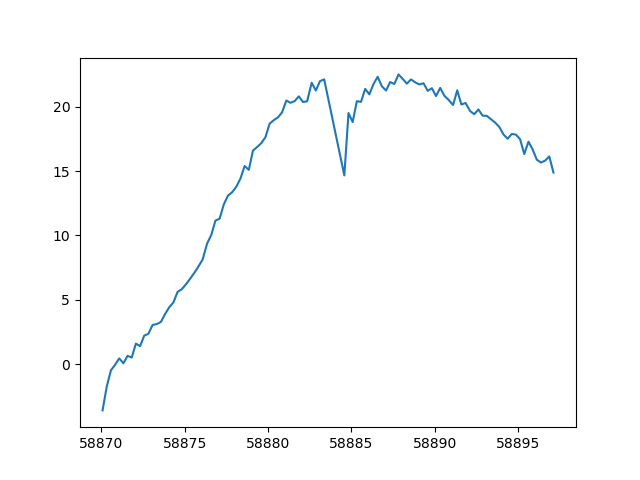

In [4]:
plt.figure()
plt.plot(lc[0],lc[1]-200)

In [5]:
tab = sd.Unified_catalog(tpf,magnitude_limit=18)
col = tab.col.values + .5
row = tab.row.values + .5
pos = np.array([col,row]).T

In [6]:
median = np.nanmedian(flux,axis=0)

In [7]:
def Isolated_stars(pos,Tmag,flux,Median, Distance = 7,Apperture=3, Mag = 16):
    """
    Find isolated stars in the scene.
    """
    print(len(pos))
    #pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)
    pos_shift = pos -.5
    ind = ((Distance//2< pos_shift[:,0]) & (pos_shift[:,0]< flux.shape[1]-Distance//2) & 
          (Distance//2< pos_shift[:,1]) & (pos_shift[:,1]< flux.shape[1]-Distance//2) &
          (Tmag < Mag))
    
    if ~ind.any():
        raise ValueError('No sources brighter than {} Tmag.'.format(Mag))
    p = pos_shift[ind,:]
    print(len(p))
    distance= np.zeros([len(p),len(p)])
    for i in range(len(p)):
        distance[i] = np.sqrt((p[i,0] - p[:,0])**2 + (p[i,1] - p[:,1])**2)
    distance[distance==0] = np.nan
    mins = np.nanmin(distance,axis=1)
    print(len(mins))
    iso = p[mins > Distance]
    iso = iso.astype('int')
    ind[ind] = mins > Distance
    median = Median
    median[median<0] = 0
    if len(iso)> 0:
        clips = []
        time_series = []
        Distance = Apperture
        if (Distance % 2) ==0:
            d = Distance - 1
        else:
            d = Distance
        u = d//2 +1
        l = d //2 

        for i in range(len(iso)):
            clips += [median[iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
            time_series += [flux[:,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
        #print(clips)
        clips=np.array(clips)
        time_series=np.array(time_series)
    else:
        raise ValueError('No stars brighter than {} Tmag and isolated by {} pix. Concider lowering brightness.'.format(Mag,Distance))
    return ind, clips, time_series

In [8]:
index, med_cut, ts = Isolated_stars(pos,tab['tmag'].values,flux,median,Distance=3)

293
79
79


In [9]:
isolated = tab.iloc[index]
ps1ind = np.isfinite(isolated['imag'].values)

In [10]:
isolated = isolated.iloc[ps1ind]
med_cut = med_cut[ps1ind]
ts = ts[ps1ind]
isolc = np.nansum(ts,axis=(2,3))

In [11]:
gr = isolated.gmag-isolated.rmag
gi = isolated.gmag-isolated.imag
ri = isolated.rmag-isolated.imag

<IPython.core.display.Javascript object>


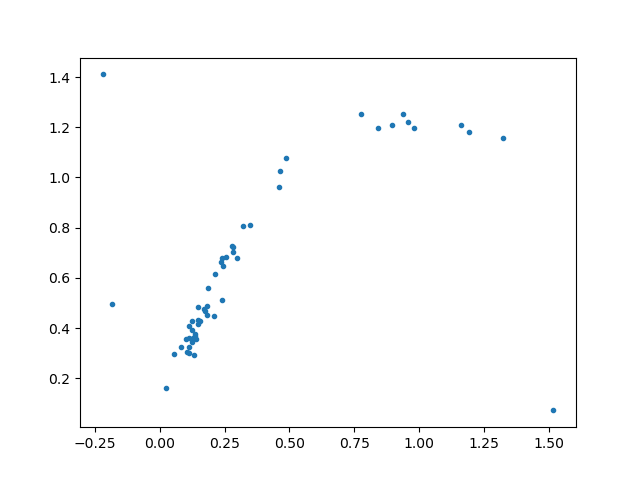

In [12]:
plt.figure()
plt.plot(ri,gr,'.')

<IPython.core.display.Javascript object>


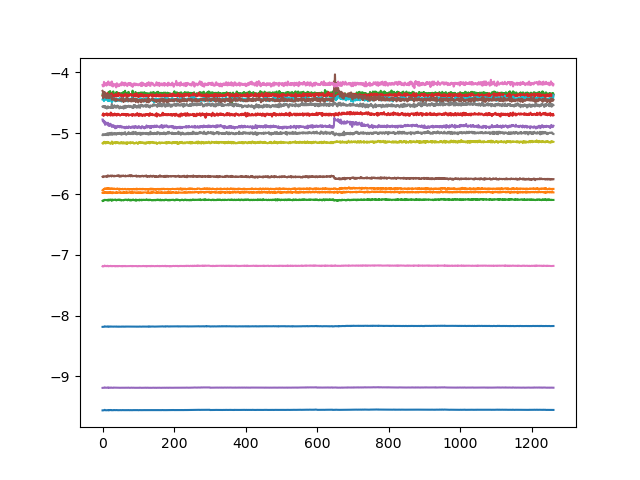

In [13]:
plt.figure()
for i in range(18):
    plt.plot(-2.5*np.log10(isolc[i]))

In [14]:
from copy import deepcopy
def Massage_df(df):
    new_cols = ['objID', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'gMeanPSFMag',
               'gMeanPSFMagErr', 'gKmag', 'e_gKmag', 'rMeanPSFMag', 'rMeanPSFMagErr', 'rKmag', 'e_rKmag',
               'iMeanPSFMag', 'iMeanPSFMagErr', 'iKmag', 'e_iKmag', 'zMeanPSFMag', 'zMeanPSFMagErr', 'zKmag',
               'e_zKmag', 'yMeanPSFMag', 'yMeanPSFMagErr', 'yKmag', 'e_yKmag', 'tmag', 'gaiaid',
               'gaiamag', 'gaiadist', 'gaiadist_u', 'gaiadist_l', 'row', 'col']
    new_df = deepcopy(df)
    new_df.columns = new_cols
    sys
    return new_df

In [15]:
niso = Massage_df(isolated)

In [16]:
niso['tessMeanPSFMag'] = -2.5*np.log10(np.nanmedian(isolc,axis=1))
niso['tessMeanPSFMagErr'] = .1

Pass 1: 0.005124999999999987
Pass 2: 0.005189062499999987


<IPython.core.display.Javascript object>


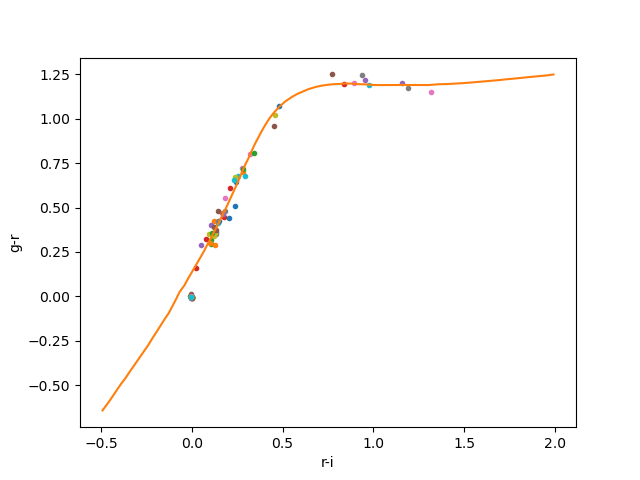

In [17]:
ex, good = sp.Tonry_reduce(niso,plot=True)

In [32]:
niso

,objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gMeanPSFMag,gMeanPSFMagErr,gKmag,e_gKmag,rMeanPSFMag,...,tmag,gaiaid,gaiamag,gaiadist,gaiadist_u,gaiadist_l,row,col,tessMeanPSFMag,tessMeanPSFMagErr
1574,181991813058841138,181.305685,61.658659,0.1554,0.2262,12.7655,0.0000,12.2497,0.0000,12.6929,...,10.5835,1582759258906136448,11.0835,3172.827079,3687.639690,2768.167191,3.631723,73.768338,-9.549842,0.1
1622,182061812667838017,181.266698,61.722702,0.0079,0.0090,14.9777,0.0021,15.0258,0.0014,14.6093,...,14.1267,1582759877381429120,14.6267,705.647608,1122.349734,496.479529,8.617912,62.768541,-5.969679,0.1
1637,182021812360799437,181.235957,61.690668,0.0033,0.0031,16.9913,0.0023,17.0815,0.0054,16.2862,...,15.8464,1582759911741167232,16.3464,NaN,NaN,NaN,2.782687,65.665002,-4.350634,0.1
1772,182061815550782157,181.555014,61.717843,0.0030,0.0066,16.1792,0.0033,16.2429,0.0024,15.8779,...,15.3908,1582762076404682112,15.8908,NaN,NaN,NaN,27.227198,78.339982,-4.374925,0.1
1866,182111816702945992,181.670037,61.762521,0.3435,0.3710,13.4211,0.0000,13.2719,0.0000,12.0106,...,10.8167,1582763347715001984,11.3167,NaN,NaN,NaN,40.150468,77.963716,-9.183805,0.1
1898,182091816160326351,181.615884,61.746338,0.0117,0.0325,16.8854,0.0077,16.9446,0.0027,15.6865,...,14.9715,1582763656952647424,15.4715,NaN,NaN,NaN,34.638179,77.461699,-5.724404,0.1
1985,182021814363602791,181.436267,61.685014,0.0060,0.0172,13.6527,0.0058,13.6953,0.0014,13.3570,...,12.8920,1582764619025321472,13.3920,NaN,NaN,NaN,15.443028,76.828655,-7.180238,0.1
2080,182141811853475682,181.185427,61.787414,0.0047,0.0037,17.4427,0.0065,17.4981,0.0055,16.1880,...,15.5252,1582766165213553664,16.0252,NaN,NaN,NaN,10.895296,49.494462,-4.997156,0.1
2084,182131812675032066,181.267548,61.776080,0.0038,0.0015,16.1820,0.0051,16.2490,0.0026,15.4539,...,15.0144,1582766302652505728,15.5144,NaN,NaN,NaN,14.992737,55.330207,-5.147737,0.1
2122,182191812217031691,181.221724,61.825749,0.0080,0.0017,16.2266,0.0025,16.2816,0.0042,15.8681,...,15.3784,1582766676314188672,15.8784,NaN,NaN,NaN,17.840278,46.001684,-4.437810,0.1


In [31]:
good

ValueError: Can only compare identically-labeled DataFrame objects

In [18]:
model = np.load('../../../source_synphot/caspec_mags2.npy',allow_pickle=True).item()

In [19]:
model

{'g': array([ 10.25057222,  16.44883333,  13.92692859,   7.78769937,
          9.27868075,   8.96618485,  14.56844385,   4.90281293,
         16.98461044,  10.24688193,  14.52746569,   7.96274815,
          9.34486059,  13.27622232,   9.27466764,  12.61383871,
         13.83675166,  15.86286601,  11.65574581,  16.65124193,
         13.63507971,   8.53825989,   8.29809598,  14.71838844,
          8.32061136,  -1.56035905,  14.44358812,  16.66583236,
          9.29614164,   9.4470222 ,  12.67446436,  16.04110975,
         15.83879266,   6.80034424,   5.6967945 ,  12.66644099,
         10.6501027 ,   9.85245998,   8.05797179,   9.37298216,
         11.57958585,  14.56335303,  10.41571086,   8.53443744,
         13.69397764,  11.41418232,  12.87805221,   9.27612176,
          6.76735509,  16.61094521,  15.64540307,   9.23137396,
          8.17450075,   9.83034241,   1.62236978,   6.83321183,
         12.66358264,   4.13243542,  12.17897891,  15.89695677,
          5.88123097,   5.55616305,

In [22]:
compare_z = np.array([['g-r','r-z'],['g-r','i-z'],['g-r','y-z'],['g-r','g-i']])
compare_tess = np.array([['g-r','r-tess'],['g-r','tess-y'],['g-r','tess-i'],['g-r','tess-z']])

zp_z, d_z = sp.Fit_zeropoint(good,model,compare_z,ex,'z')
zp_tess, d_tess = sp.Fit_zeropoint(good,model,compare_tess,ex,'tess')

In [24]:
zp_z

array([-0.0496221])

<IPython.core.display.Javascript object>


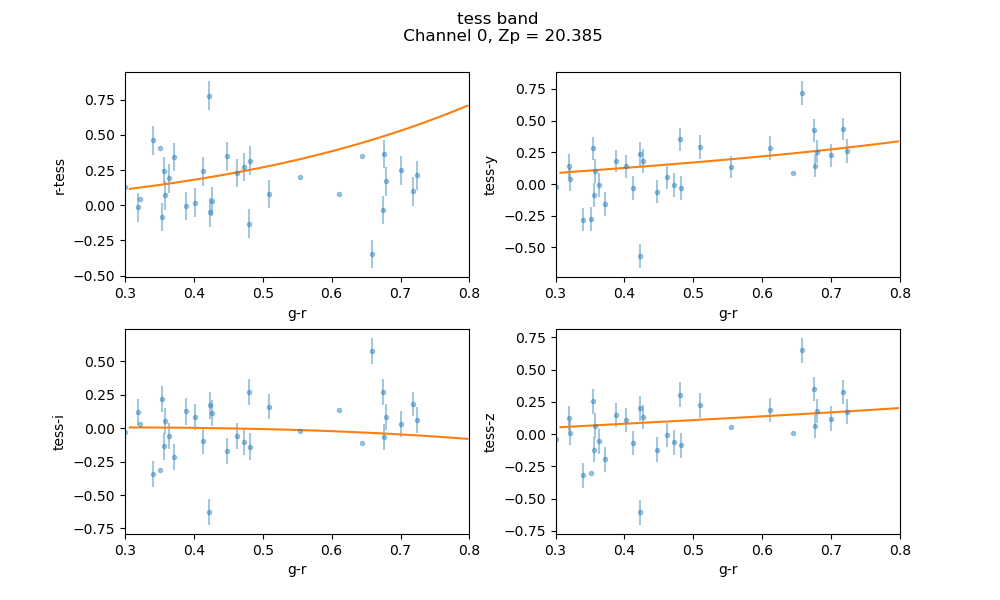

<IPython.core.display.Javascript object>


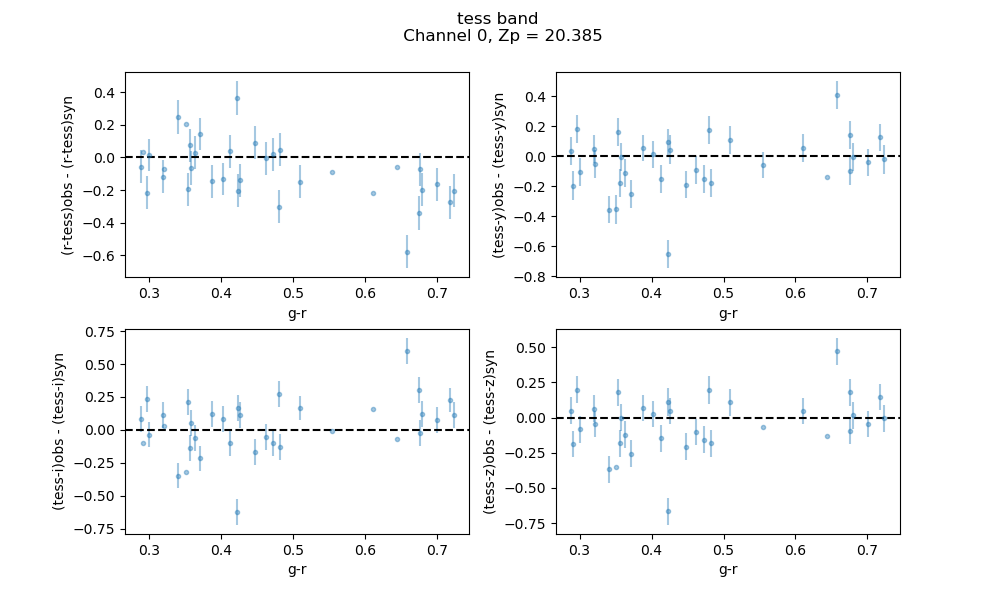

In [37]:
c_tess = sp.Make_colours(d_z,model,compare_tess,Extinction = ex)
sp.Plotter(zp_tess,c_tess,compare_tess,0,0,'tess','test',Close=False)
sp.Plotter(zp_tess,c_tess,compare_tess,0,0,'tess','test',Residuals=True,Close=False)

<IPython.core.display.Javascript object>


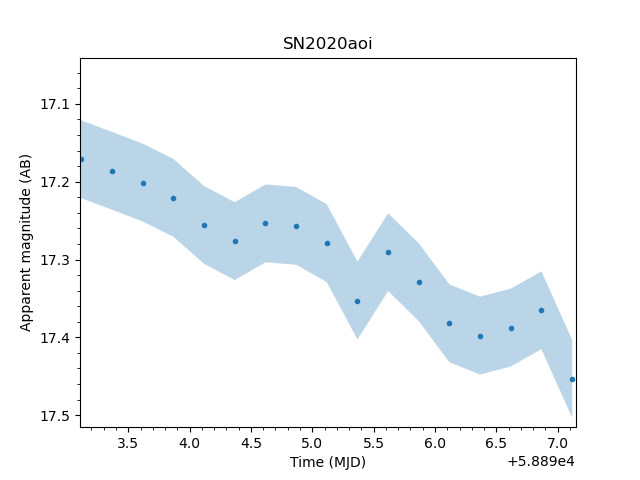

(21.0, 16.5)

In [42]:
mag = -2.5*np.log10(lc[1]-200) + zp_tess
mag1 = -2.5*np.log10(lc[1]-200) + zp_tess - 0.05
mag2 = -2.5*np.log10(lc[1]-200) + zp_tess + 0.05
plt.figure()
plt.fill_between(lc[0],mag1,mag2,alpha = 0.3)
plt.plot(lc[0],mag,'.')

plt.gca().invert_yaxis()
plt.ylabel('Apparent magnitude (AB)')
plt.xlabel('Time (MJD)')
plt.title('SN2020aoi')
plt.minorticks_on()
plt.ylim(21,16.5)
#plt.savefig('sn2020aoi_cal.png')

In [26]:
def Time_series_zp(df,timeseries,ex,model):
    zps_t = []
    zps_z = []
    
    compare_z = np.array([['g-r','r-z'],['g-r','i-z'],['g-r','y-z'],['g-r','g-i']])
    compare_tess = np.array([['g-r','r-tess'],['g-r','tess-y'],['g-r','tess-i'],['g-r','tess-z']])
    
    mags = -2.5*np.log10(timeseries)
    for i in range(len(mags)):
        data = deepcopy(df)
        data['tessMeanPSFMag'] = mags[i]
        data['tessMeanPSFMagErr'] = 0.1
        
        zp_z, d_z = sp.Fit_zeropoint(data,model,compare_z,ex,'z')
        zp_tess, d_tess = sp.Fit_zeropoint(data,model,compare_tess,ex,'tess')
        zps_t += [zp_tess]
        zps_z += [zpz]
    zps_z = np.array(zps_z)
    zps_t = np.array(zps_t)
    return zps_z, zps_t

In [27]:
zpsz, zpst = Time_series_zp(good,isolc,ex,model)

ValueError: Length of values (1262) does not match length of index (51)

In [29]:
isolc.shape

(54, 1262)